In [446]:
import os
import sys
from math import log
import numpy as np
incrementer = 0.0000000000000001

In [447]:
def getFileContents(filename):
    data = None
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [448]:
def getFileFromCommandLine():
    filename = sys.argv[1]
    return getFileContents(filename)

In [449]:
def splitWordTag(word_tag_pair):
    splitted = word_tag_pair.split('/')
    tag = splitted[-1]
    word = '/'.join(splitted[:-1])
    return word, tag

In [450]:
def getUniqueTags(tagged_data):
    tags = {}
    for line in tagged_data:
        word_tag_pairs = line.strip().split(' ')
        for word_tag_pair in word_tag_pairs:
            word, tag = splitWordTag(word_tag_pair)
            if tag in tags.keys():
                tags[tag] += 1
            else:
                tags[tag] = 1
    return tags

In [451]:
def getOpenProbabilities(tagged_data, all_tags_dict):
    global incrementer
    sentences_count = len(tagged_data)
    open_tag_count_dict = {}
    for line in tagged_data:
        first_word_tag_pairs = line.strip().split(' ')[0]
        word, tag = splitWordTag(first_word_tag_pairs)
        if tag in open_tag_count_dict.keys():
            open_tag_count_dict[tag] += 1
        else:
            open_tag_count_dict[tag] = 1
    
    #increment all existing tags count to one
    open_tag_count_dict.update((tag, occurances + incrementer) for tag, occurances in open_tag_count_dict.items())
    sentences_count += (sentences_count*incrementer)
    
    #add one two non-opening tags
    for tag in all_tags_dict.keys():
        try:
            val = open_tag_count_dict[tag]
        except KeyError as e:
            open_tag_count_dict[tag] = incrementer
            sentences_count += incrementer
    
    open_tag_count_dict.update((tag, log((occurances*1.0)/sentences_count)) for tag, occurances in open_tag_count_dict.items())
    return open_tag_count_dict

In [452]:
def getCloseProbabilities(tagged_data, all_tags_dict):
    global incrementer
    sentences_count = len(tagged_data)
    close_tag_count_dict = {}
    for line in tagged_data:
        last_word_tag_pairs = line.strip().split(' ')[-1]
        word, tag = splitWordTag(last_word_tag_pairs)
        if tag in close_tag_count_dict.keys():
            close_tag_count_dict[tag] += 1
        else:
            close_tag_count_dict[tag] = 1
            
    #increment all existing tags count to one
    close_tag_count_dict.update((tag, occurances + incrementer) for tag, occurances in close_tag_count_dict.items())
    sentences_count += (sentences_count*incrementer)
    
    #add one two non-closing tags
    for tag in all_tags_dict.keys():
        try:
            val = close_tag_count_dict[tag]
        except KeyError as e:
            close_tag_count_dict[tag] = incrementer
            sentences_count += incrementer
            
    close_tag_count_dict.update((tag, log((occurances*1.0)/sentences_count)) for tag, occurances in close_tag_count_dict.items())
    return close_tag_count_dict

In [453]:
def buildTransitionMatrix(tagged_data, tags_dict):
    global incrementer
    tags = tags_dict.keys()
    tags.sort()
    
    tags_index_dict = {}
    for index, tag in enumerate(tags):
        tags_index_dict[tag] = index
    
    tag_count = len(tags)
    
    #Change this line to np.ones for add 1 smoothing
    transition_matrix = np.zeros(shape=(tag_count, tag_count))
    
    for line in tagged_data:
        prev_tag = None
        word_tag_pairs = line.strip().split(' ')
        
        for word_tag_pair in word_tag_pairs:
            word, tag = splitWordTag(word_tag_pair)
            
            if prev_tag is not None:
                transition_matrix[tags_index_dict[prev_tag]][tags_index_dict[tag]] += 1
            
            prev_tag = tag
            
    transition_matrix = transition_matrix + incrementer
    probability_transition_matrix = transition_matrix/transition_matrix.sum(axis=1, keepdims=True)
    print "Transition Values are NaN : ", np.argwhere(np.isnan(probability_transition_matrix))
    probability_transition_matrix[np.isnan(probability_transition_matrix)] = incrementer
    probability_transition_matrix = np.log(probability_transition_matrix)
    return probability_transition_matrix, tags_index_dict
        

In [454]:
def getUniqueWords(tagged_data):
    words = []
    for line in tagged_data:
        word_tag_pairs = line.strip().split(' ')
        
        for word_tag_pair in word_tag_pairs:
            word, tag = splitWordTag(word_tag_pair)
            words.append(word)
    return list(set(words))

In [455]:
def computeEmissionProbabilities(tagged_data, tags_dict):
    global incrementer
    tags = tags_dict.keys()
    tags.sort()
    
    words = getUniqueWords(tagged_data)
    words.sort()
    
    tags_index_dict = {}
    for index, tag in enumerate(tags):
        tags_index_dict[tag] = index
        
    words_index_dict = {}
    for index, word in enumerate(words):
        words_index_dict[word] = index
    
    tag_count = len(tags)
    word_count = len(words)
    
    # word_count + 1 => Last column for unseen words
    emission_matrix = np.zeros(shape=(tag_count, word_count + 1))
    
    for line in tagged_data:
        prev_tag = None
        word_tag_pairs = line.strip().split(' ')
        
        for word_tag_pair in word_tag_pairs:
            word, tag = splitWordTag(word_tag_pair)
            
            emission_matrix[tags_index_dict[tag]][words_index_dict[word]] += 1
            
            prev_tag = tag
    #increment 1 in all the elements so that the last col for unseen words have non zero values
    emission_matrix = emission_matrix + incrementer
    probability_emission_matrix = emission_matrix/emission_matrix.sum(axis=1, keepdims=True)
    print "Emission Values are NaN : ", np.argwhere(np.isnan(probability_emission_matrix))
    probability_emission_matrix[np.isnan(probability_emission_matrix)] = incrementer
    probability_emission_matrix = np.log(probability_emission_matrix)
    return probability_emission_matrix, tags_index_dict, words_index_dict

In [456]:
def printEmissionProbabilities(count):
    counter = 0
    global probability_emission_matrix, tags_index_dict, words_index_dict
    word_count = len(words_index_dict.keys())
    tag_count = len(tags_index_dict.keys())
    for word, word_index in words_index_dict.iteritems():
        for tag, tag_index in tags_index_dict.iteritems():
            if probability_emission_matrix[tag_index][word_index] != 0:
                print tag, " => ", word, ' => ', probability_emission_matrix[tag_index][word_index]
                counter += 1
                if counter > count:
                    return

In [514]:
unseen_words = {}
def getMostProbableTags(sentence):
    global opening_probabilities, closing_probabilities, probability_transition_matrix, probability_emission_matrix, tags_index_dict, words_index_dict
    global tag_count, unseen_words
    
    
    correct = 0
    total = 0
    for index, test_line in enumerate(dev_untagged_data):
        predicted_tagged_line = getMostProbableTags(test_line)
        expected_tagged_line = dev_tagged_data[index]
        predicted_word_tag_pairs = predicted_tagged_line.strip().split(' ')
        expected_word_tag_pairs = expected_tagged_line.strip().split(' ')
        for index, predicted_word in enumerate(predicted_word_tag_pairs):
            if predicted_word == expected_word_tag_pairs[index]:
                correct += 1
            total += 1
            if total % 100 == 0:
                print correct, total, " => ", (correct*100.0)/total
    accuracy = (correct*100.0)/total
    print accuracy


    
    sentence_words = sentence.strip().split(' ')
    
    sentence_len = len(sentence_words)
    
    viterbi_matrix = np.zeros(shape=(tag_count, sentence_len))
    
    tracing_matrix = [[None for x in range(sentence_len)] for y in range(tag_count)]
    
    for word_index in range(sentence_len):
        word = sentence_words[word_index]
        for model_tag, model_tag_index in tags_index_dict.iteritems():
            
            try:
                word_emission_probability = probability_emission_matrix[model_tag_index][words_index_dict[word]]
            except KeyError as e:
                word_emission_probability = probability_emission_matrix[model_tag_index][-1]
                try:
                    unseen_words[word] += 1
                except KeyError as e:
                    unseen_words[word] = 1
                
            
            if word_index == 0:
                try:
                    tag_opening_probability = opening_probabilities[model_tag]
                except KeyError as e:
                    print "tag_opening_probability : Keyerror encountered"
                    tag_opening_probability = 1.1754943508222875e-10
                viterbi_matrix[model_tag_index][word_index] = tag_opening_probability + word_emission_probability
            else:
                max_probability = np.finfo(float).min
                max_tag = None
                for prev_model_tag, prev_model_tag_index in tags_index_dict.iteritems():
                    tag_transition_probability = probability_transition_matrix[prev_model_tag_index][model_tag_index]
                    if tag_transition_probability == 0.0:
                        print "Transition probability still zero"
                        tag_transition_probability = 1.1754943508222875e-10
                    temp_probability = viterbi_matrix[prev_model_tag_index][word_index-1] + tag_transition_probability + word_emission_probability  
                    if temp_probability > max_probability:
                        max_probability = temp_probability
                        max_tag = prev_model_tag
                        
                viterbi_matrix[model_tag_index][word_index] = max_probability
                tracing_matrix[model_tag_index][word_index] = max_tag
    
    max_probability = np.finfo(float).min
    max_probability_tag = None
    for model_tag, model_tag_index in tags_index_dict.iteritems():
        temp_probability = 0.0
        try:
            tag_closing_probabilities = closing_probabilities[model_tag]
        except KeyError as e:
            print "tag_closing_probabilities : Keyerror encountered", 
            tag_closing_probabilities = 1.1754943508222875e-10
        temp_probability =  tag_closing_probabilities + viterbi_matrix[model_tag_index][sentence_len-1]
        if temp_probability > max_probability:
            max_probability = temp_probability
            max_probability_tag = model_tag

    assigned_tags = [max_probability_tag]
    current_best_tag = max_probability_tag
    for col in range(sentence_len-1, 0, -1):
        current_best_tag = tracing_matrix[tags_index_dict[current_best_tag]][col]
        assigned_tags.append(current_best_tag)
    assigned_tags = assigned_tags[::-1]
    
    anotated_sentence = ''
    for index, assigned_tag in enumerate(assigned_tags):
        anotated_sentence += str(sentence_words[index]) + '/' + str(assigned_tag) + ' '
    
    
    return anotated_sentence.strip()
    
    

In [515]:
np.finfo(float).min

-1.7976931348623157e+308

In [516]:
tagged_data = getFileContents('data/en_train_tagged.txt')
tags_dict = getUniqueTags(tagged_data)

In [517]:
opening_probabilities = getOpenProbabilities(tagged_data, tags_dict)
closing_probabilities = getCloseProbabilities(tagged_data, tags_dict)

In [518]:
probability_transition_matrix, tags_index_dict = buildTransitionMatrix(tagged_data, tags_dict)

Transition Values are NaN :  []


In [519]:
probability_emission_matrix, tags_index_dict, words_index_dict = computeEmissionProbabilities(tagged_data, tags_dict)

Emission Values are NaN :  []


In [520]:
printEmissionProbabilities(5)

PRP$  =>  Unemployent  =>  -44.8701426504
VBG  =>  Unemployent  =>  -44.9520890709
FW  =>  Unemployent  =>  -41.3739609811
NFP  =>  Unemployent  =>  -42.6644073834
``  =>  Unemployent  =>  -43.5420925975
VBN  =>  Unemployent  =>  -45.126874797


In [521]:
tag_count = len(tags_index_dict.keys())

In [522]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [523]:

# sentence = "Bush also nominated A. Noel Anketell Kramer for a 15 - year term as associate judge of the District of Columbia Court of Appeals , replacing John Montague Steadman ."
sentence = "The sheikh in wheel - chair has been attacked with a F - 16 - launched bomb ."
# sentence = "the Pakistan military"
getMostProbableTags(sentence)

'The/DT sheikh/JJS in/IN wheel/NN -/HYPH chair/NN has/VBZ been/VBN attacked/VBN with/IN a/DT F/NNP -/HYPH 16/CD -/HYPH launched/VBN bomb/NN ./.'

In [524]:
dev_tagged_data = getFileContents('data/en_dev_tagged.txt')
dev_untagged_data = getFileContents('data/en_dev_raw.txt')

In [525]:
correct = 0
total = 0
for index, test_line in enumerate(dev_untagged_data):
    predicted_tagged_line = getMostProbableTags(test_line)
    expected_tagged_line = dev_tagged_data[index]
    predicted_word_tag_pairs = predicted_tagged_line.strip().split(' ')
    expected_word_tag_pairs = expected_tagged_line.strip().split(' ')
    for index, predicted_word in enumerate(predicted_word_tag_pairs):
        if predicted_word == expected_word_tag_pairs[index]:
            correct += 1
        total += 1
        if total % 100 == 0:
            print correct, total, " => ", (correct*100.0)/total
accuracy = (correct*100.0)/total
print accuracy

85 100  =>  85.0
178 200  =>  89.0
267 300  =>  89.0
357 400  =>  89.25
452 500  =>  90.4
539 600  =>  89.8333333333
628 700  =>  89.7142857143
717 800  =>  89.625
803 900  =>  89.2222222222
895 1000  =>  89.5
984 1100  =>  89.4545454545
1071 1200  =>  89.25
1163 1300  =>  89.4615384615
1240 1400  =>  88.5714285714
1324 1500  =>  88.2666666667
1418 1600  =>  88.625
1506 1700  =>  88.5882352941
1595 1800  =>  88.6111111111
1685 1900  =>  88.6842105263
1777 2000  =>  88.85
1863 2100  =>  88.7142857143
1951 2200  =>  88.6818181818
2045 2300  =>  88.9130434783
2133 2400  =>  88.875
2230 2500  =>  89.2
2314 2600  =>  89.0
2403 2700  =>  89.0
2490 2800  =>  88.9285714286
2582 2900  =>  89.0344827586
2668 3000  =>  88.9333333333
2758 3100  =>  88.9677419355
2845 3200  =>  88.90625
2933 3300  =>  88.8787878788
3015 3400  =>  88.6764705882
3104 3500  =>  88.6857142857
3189 3600  =>  88.5833333333
3281 3700  =>  88.6756756757
3367 3800  =>  88.6052631579
3455 3900  =>  88.5897435897
3546 4000  =

In [412]:
unseen_words

{'NYT': 50,
 'Abbas': 500,
 'perverted': 100,
 'Imbalance': 100,
 'Foundation': 50,
 'Hangout': 50,
 'calculate': 100,
 'insurgencies': 50,
 'punjab': 100,
 'Jennings': 50,
 'Sewell': 50,
 'Shirley': 50,
 'ergo': 50,
 'Fix': 50,
 'GT': 50,
 'HANO': 300,
 'communique': 50,
 'sellers': 100,
 'GG': 50,
 'digic': 50,
 'crops': 50,
 'relentlessly': 50,
 'unrelated': 50,
 'notifying': 50,
 'Malach': 50,
 '29th': 50,
 'W.H.S.': 50,
 'Matthew': 100,
 'crave': 100,
 'http://www.4gamer.net/news/image/2005.09/20050917034321_2big.html': 50,
 'julie...@bellsouth.net': 50,
 'Townsend': 50,
 'pander': 50,
 'revolutionize': 50,
 'asia': 100,
 'pinchers': 50,
 'Amazon': 50,
 'Newsgroups': 100,
 'coefficient': 50,
 'statehood': 50,
 'meh': 50,
 'Sts.': 50,
 'Curry': 50,
 'conversational': 50,
 'Adz': 100,
 'luggage': 50,
 'auction': 50,
 'Surprisingly': 50,
 'TJO': 50,
 'jill': 50,
 'browsing': 50,
 'redevelopment': 50,
 'Harvey': 50,
 '9/30/01': 50,
 'Reverting': 50,
 'Epic': 100,
 'Drugs': 50,
 'sweat

In [526]:
from matplotlib import pyplot as plt
%matplotlib inline

In [532]:
arr = [1,2,3,1,2,5,6,7,8,8,9,10,11,12,12,13,17,18,20,20,21,22,21,15]
arr.sort()
print arr

[1, 1, 2, 2, 3, 5, 6, 7, 8, 8, 9, 10, 11, 12, 12, 13, 15, 17, 18, 20, 20, 21, 21, 22]


(array([ 208.,  171.,  120.,   92.,   79.,   71.,   56.,   35.,   44.,
          21.,   30.,   17.,   16.,    7.,    7.,    3.,    9.,    5.,
           2.,    1.,    1.,    0.,    0.,    1.,    1.,    0.,    2.,
           0.,    0.,    1.]),
 array([  3.11612006e-05,   4.53881302e-02,   9.07450992e-02,
          1.36102068e-01,   1.81459037e-01,   2.26816006e-01,
          2.72172975e-01,   3.17529944e-01,   3.62886913e-01,
          4.08243882e-01,   4.53600851e-01,   4.98957820e-01,
          5.44314789e-01,   5.89671758e-01,   6.35028727e-01,
          6.80385696e-01,   7.25742665e-01,   7.71099634e-01,
          8.16456603e-01,   8.61813572e-01,   9.07170541e-01,
          9.52527510e-01,   9.97884479e-01,   1.04324145e+00,
          1.08859842e+00,   1.13395539e+00,   1.17931236e+00,
          1.22466932e+00,   1.27002629e+00,   1.31538326e+00,
          1.36074023e+00]),
 <a list of 30 Patch objects>)

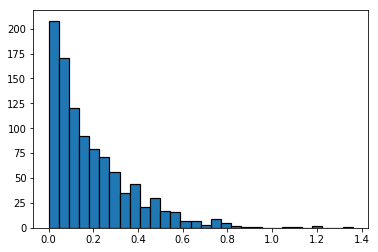

In [546]:
from sys import argv
from math import *
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

theta = 0.2
lamb = 1.0/theta
n = 1000

def genX():
    u = random.uniform(0,1)
    while(u == 0 or u == 1):
        u = random.uniform(0,1)
    return u


def genexp(u):
    #u= genX()
    x=(-1.0/lamb)*log(1-u)
    return x

axis = {}

for i in range(n):
    u = genX()
    axis[u] = genexp(u)

#axis.keys() = sorted(axis.keys())


arr = axis.values()
binwidth = (max(arr) - min(arr))/30.0
plt.hist(arr, bins=np.arange(min(arr), max(arr) + binwidth, binwidth), edgecolor='black', linewidth=1.2)